In [ ]:
from configparser import ConfigParser

config = ConfigParser()
config.read('config.ini')
config['augmentations']['pad_trunc_noise_multiplier']


In [ ]:
from torchsummary import summary
summary(model, (1,257, 63))

In [ ]:
import torch
from loader.AudioDataset import specMask, collate_batch, createDataset
from torch.utils.data import Dataset
import loader.utils as utils
import matplotlib.pyplot as plt
import model
import random

random.seed(10)
torch.manual_seed(10)

linux = '/media/jianquan/Data/Processed Audio/'
windows = 'E:/Processed Audio/'

audio_paths, _ = utils.getAudioPaths(windows)

audio_train_dataset = createDataset(audio_paths, transformParams = utils.getTransforms(False), outputAudio = True)

test_dataloader = torch.utils.data.DataLoader(
    audio_train_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_batch
)
batch = next(iter(test_dataloader))
batch_size = len(batch[0])

nfftList = [64, 128, 256, 512, 1024]
classList = [0, 1, 2]

for nfft in nfftList:
    for specClass in classList:
        saveName = f'nfft{nfft}_class{specClass}'
        print(saveName, end=': ')
        testModel = model.CNNNetwork(nfft, specClass)
        testModel(batch[0])
        plt.savefig(f'./spec/spec/whisper Norm/{saveName}.png')


# import IPython.display as ipd
# ipd.Audio(batch[0][3], rate = 8000)
# for b in batch[0]:
#     # print(b.max(),b.median(),b.mean(), b.min())
#     # print(b).

    
#     plt.plot(b[0])
#     plt.show()

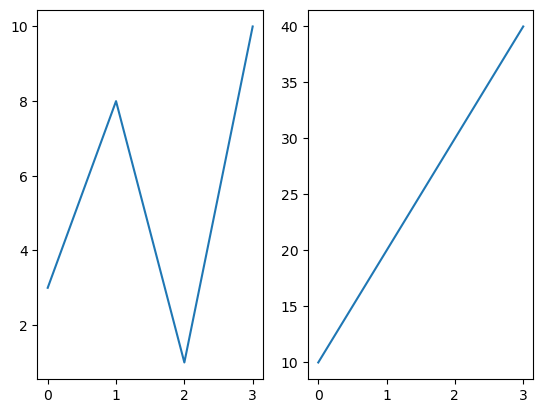

In [1]:
import matplotlib.pyplot as plt
import numpy as np

#plot 1:
x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(1, 2, 1)
plt.plot(x, y)

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 2, 2)
plt.plot(x, y)

plt.show()
